# Predict diabetes based on diagnostic measures

##### Activity performed for the discipline "Data Mining"

##### [Matheus Pimenta](https://github.com/omatheuspimenta)

### Accessed in Oct. 2021

### Available [here](diabetes.csv)
### [Kaggle](https://www.kaggle.com/houcembenmansour/predict-diabetes-based-on-diagnostic-measures)
## Description

### Context

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. 

### Content
The datasets consists of several medical predictor variables and one target variable, diabetes. Predictor variables includes the number of pregnancies the patient has had, their BMI, weight, age,glucose, and so on.

### Inspiration
Can you build a machine learning model to accurately predict whether or not the patients in the dataset have diabetes or not?

### For more information visit the Kaggle site.

## Importing the libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score, roc_curve, auc, roc_auc_score

## Load the dataset using Pandas API


In [2]:
df = pd.read_csv('diabetes.csv',
                 header = 0)

## Getting some information about the dataset


In [3]:
print("Dataset shape:{}\nThere are {} rows and {} columns.".format(
    df.shape, df.shape[0], df.shape[1]))
df.head(3)

Dataset shape:(390, 16)
There are 390 rows and 16 columns.


,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,1,193,77,49,"3,9",19,female,61,119,"22,5",118,70,32,38,"0,84",No diabetes
1,2,146,79,41,"3,6",19,female,60,135,"26,4",108,58,33,40,"0,83",No diabetes
2,3,217,75,54,4,20,female,67,187,"29,3",110,72,40,45,"0,89",No diabetes


In [4]:
df.dtypes

patient_number      int64
cholesterol         int64
glucose             int64
hdl_chol            int64
chol_hdl_ratio     object
age                 int64
gender             object
height              int64
weight              int64
bmi                object
systolic_bp         int64
diastolic_bp        int64
waist               int64
hip                 int64
waist_hip_ratio    object
diabetes           object
dtype: object

## Data preprocess

In [5]:
df = df.drop(columns="patient_number")
df.select_dtypes(include=['object']).columns

Index(['chol_hdl_ratio', 'gender', 'bmi', 'waist_hip_ratio', 'diabetes'], dtype='object')

## Violin plot

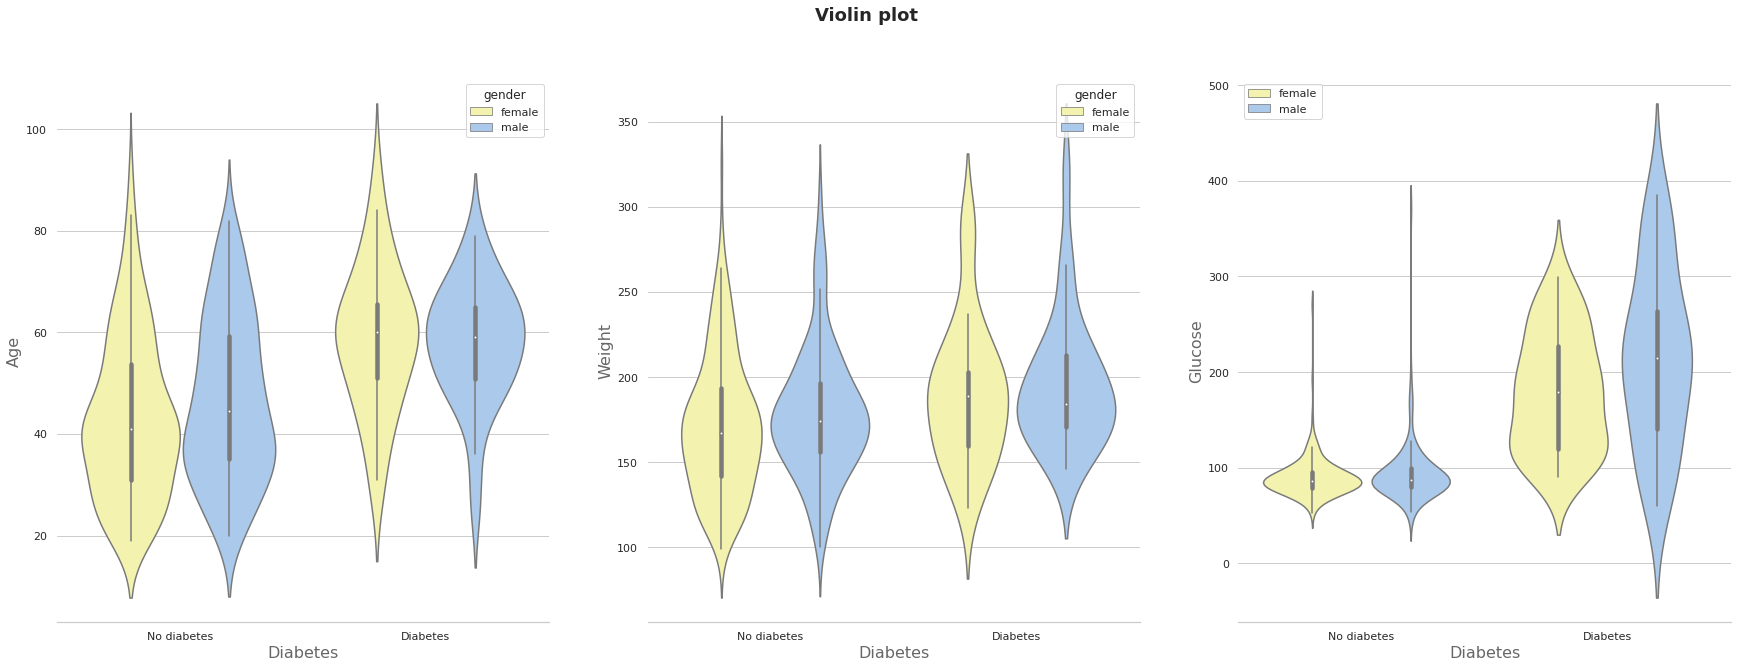

In [6]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

f, ax = plt.subplots(1,3,figsize=(30, 10))
sns.violinplot(x=df["diabetes"], y=df["age"], hue=df["gender"],
            palette={"male": "b", "female": "y"}, ax=ax[0])
sns.despine(left=True)
ax[0].set_xlabel("Diabetes",size = 16,alpha=0.7)
ax[0].set_ylabel("Age",size = 16,alpha=0.7)

sns.violinplot(x=df["diabetes"], y=df["weight"], hue=df["gender"],
             palette={"male": "b", "female": "y"}, ax=ax[1])
sns.despine(left=True)
ax[1].set_xlabel("Diabetes",size = 16,alpha=0.7)
ax[1].set_ylabel("Weight",size = 16,alpha=0.7)

sns.violinplot(x=df["diabetes"], y=df["glucose"], hue=df["gender"],
             palette={"male": "b", "female": "y"}, ax=ax[2])
sns.despine(left=True)
ax[2].set_xlabel("Diabetes",size = 16,alpha=0.7)
ax[2].set_ylabel("Glucose",size = 16,alpha=0.7)

f.suptitle('Violin plot', fontsize=18, fontweight='bold')
plt.legend(loc='upper left')#, labels=['Male', 'Female'])
plt.show()

## Correlation

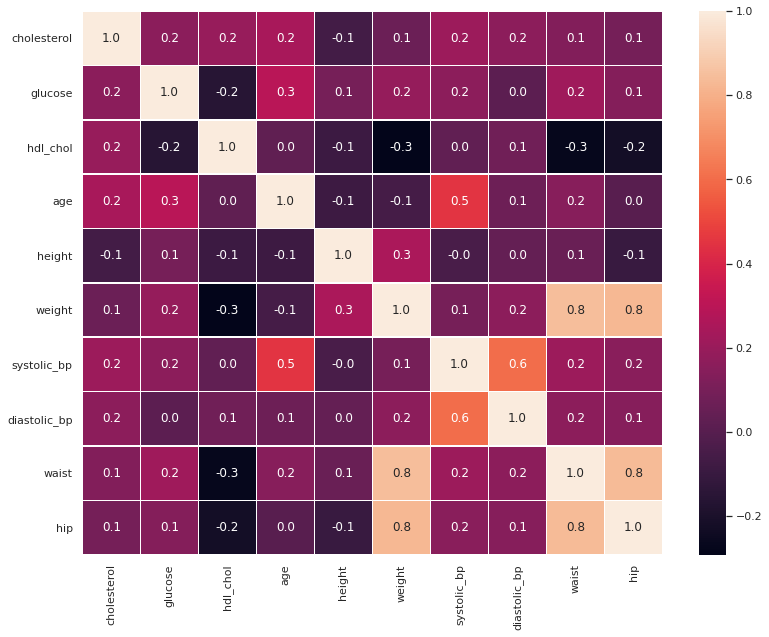

In [7]:
f,ax = plt.subplots(figsize=(13, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Observing the results above, we can see some features with a high correlation between them. When we look at the 'diabetes' column, the highest correlation occurs between the 'glucose' column. (in the case of convert the 'diabetes' column to binary representation)

## Random Forest

#### Preprocess

In [8]:
class_diabetes = df['diabetes']
gender = df['gender']
del df['diabetes']
del df['gender']
df.replace(to_replace=",", value=".", inplace=True, regex=True)
df['chol_hdl_ratio'] = df['chol_hdl_ratio'].astype(float)
col_names = df.columns

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)
df = pd.DataFrame(df_minmax)

In [10]:
df.columns = col_names
df['gender'] = gender
df['diabetes'] = class_diabetes
df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,gender,diabetes
0,0.315068,0.086053,0.342593,0.134831,0.000000,0.375000,0.088496,0.179803,0.1750,0.289474,0.200000,0.235294,0.347826,female,No diabetes
1,0.186301,0.091988,0.268519,0.117978,0.000000,0.333333,0.159292,0.275862,0.1125,0.131579,0.233333,0.294118,0.326087,female,No diabetes
2,0.380822,0.080119,0.388889,0.140449,0.013699,0.625000,0.389381,0.347291,0.1250,0.315789,0.466667,0.441176,0.456522,female,No diabetes
3,0.405479,0.145401,0.537037,0.095506,0.013699,0.500000,0.066372,0.108374,0.2000,0.210526,0.166667,0.264706,0.239130,female,No diabetes
4,0.235616,0.127596,0.509259,0.050562,0.013699,0.750000,0.185841,0.123153,0.2000,0.500000,0.200000,0.264706,0.304348,female,No diabetes


In [11]:
df["diabetes"] = np.where(df["diabetes"].str.contains("Diabetes"),1,0)
df_dummy = pd.get_dummies(data=df, columns=['gender'])

In [12]:
class_diabetes = df_dummy['diabetes']
del df_dummy['diabetes']
df_dummy['diabetes'] = class_diabetes
df_dummy.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,gender_female,gender_male,diabetes
0,0.315068,0.086053,0.342593,0.134831,0.000000,0.375000,0.088496,0.179803,0.1750,0.289474,0.200000,0.235294,0.347826,1,0,0
1,0.186301,0.091988,0.268519,0.117978,0.000000,0.333333,0.159292,0.275862,0.1125,0.131579,0.233333,0.294118,0.326087,1,0,0
2,0.380822,0.080119,0.388889,0.140449,0.013699,0.625000,0.389381,0.347291,0.1250,0.315789,0.466667,0.441176,0.456522,1,0,0
3,0.405479,0.145401,0.537037,0.095506,0.013699,0.500000,0.066372,0.108374,0.2000,0.210526,0.166667,0.264706,0.239130,1,0,0
4,0.235616,0.127596,0.509259,0.050562,0.013699,0.750000,0.185841,0.123153,0.2000,0.500000,0.200000,0.264706,0.304348,1,0,0


In [13]:
pd.options.display.float_format = "{:.3f}".format
df_dummy.describe().T

,count,mean,std,min,25%,50%,75%,max
cholesterol,390.000,0.354,0.122,0.000,0.277,0.342,0.414,1.000
glucose,390.000,0.176,0.160,0.000,0.098,0.125,0.177,1.000
hdl_chol,390.000,0.354,0.160,0.000,0.241,0.315,0.435,1.000
chol_hdl_ratio,390.000,0.170,0.098,0.000,0.096,0.152,0.219,1.000
age,390.000,0.380,0.225,0.000,0.205,0.349,0.562,1.000
height,390.000,0.581,0.163,0.000,0.458,0.583,0.708,1.000
weight,390.000,0.347,0.179,0.000,0.227,0.327,0.447,1.000
bmi,390.000,0.334,0.163,0.000,0.219,0.310,0.421,1.000
systolic_bp,390.000,0.295,0.143,0.000,0.200,0.288,0.363,1.000
diastolic_bp,390.000,0.464,0.178,0.000,0.355,0.447,0.553,1.000


##### Splitting the dataset

In [14]:
X = df_dummy.drop('diabetes',axis=1)
Y = df_dummy['diabetes']

ND, D = Y.value_counts(sort=True) #sort=True (default) in order to be sure B, M are in the right order (alphabetical)
print('Number of Non diabetes: ', ND)
print('Number of Diabetes: ', D)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=0.2,
                                                    stratify=Y)

Number of Non diabetes:  330
Number of Diabetes:  60


## Random Forest using all features

In [15]:
RF = RandomForestClassifier(n_estimators = 100)
RF.fit(X_train,y_train)

RandomForestClassifier()

In [16]:
n_splits = 10
seed = 7
cv = RepeatedStratifiedKFold(n_splits=n_splits, 
                             n_repeats=n_splits, 
                             random_state=seed)

In [17]:
n_scores = cross_validate(RF,
                          X, 
                          Y, 
                          scoring='accuracy', 
                          cv=cv, 
                          n_jobs=-1, 
                          error_score='raise')
print("Mean:", np.mean(n_scores['test_score']))

Mean: 0.9058974358974359


In [18]:
RF100_res = RF.predict(X_test)
RF100_cm = confusion_matrix(y_true=y_test, 
                            y_pred=RF100_res)

Text(0.5, 1.0, 'Heatmap for Random Forest Classification Model using all features')

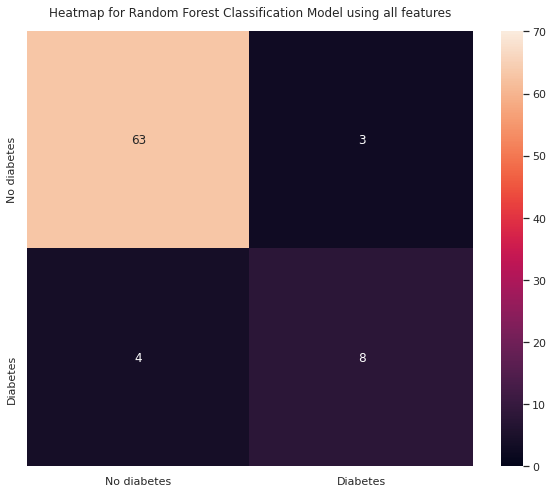

In [19]:
plt.figure(figsize = (10,8))
ax = plt.axes()
x_axis_labels = ['No diabetes', 'Diabetes'] # labels for x-axis
y_axis_labels = ['No diabetes', 'Diabetes'] # labels for y-axis
sns.heatmap(RF100_cm,
            vmin=0,
            vmax=70,
            annot=True,
            fmt="d",
            ax = ax,
            xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels)
ax.set_title('Heatmap for Random Forest Classification Model using all features',pad=15)

In [20]:
print(classification_report(y_test, RF100_res, target_names=['No diabetes', 'Diabetes']))
print("Accuracy:",accuracy_score(y_test, RF100_res))

              precision    recall  f1-score   support

 No diabetes       0.94      0.95      0.95        66
    Diabetes       0.73      0.67      0.70        12

    accuracy                           0.91        78
   macro avg       0.83      0.81      0.82        78
weighted avg       0.91      0.91      0.91        78

Accuracy: 0.9102564102564102


## Feature Selection
## RFE method

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=0.2,
                                                    stratify=Y)

In [26]:
# Create the RFE object and rank each pixel
RFE_RF100 = RandomForestClassifier(n_estimators = 100)  
rfe = RFE(estimator=RFE_RF100, n_features_to_select=1, step=1)
rfe = rfe.fit(X_train, y_train)
print('Features - RFE:',X_train.columns[rfe.support_])

print(classification_report(y_test, rfe.predict(X_test), target_names=['No diabetes', 'Diabetes']))
print("Accuracy:",accuracy_score(y_test, rfe.predict(X_test)))

Features - RFE: Index(['glucose'], dtype='object')
              precision    recall  f1-score   support

 No diabetes       0.94      0.94      0.94        66
    Diabetes       0.67      0.67      0.67        12

    accuracy                           0.90        78
   macro avg       0.80      0.80      0.80        78
weighted avg       0.90      0.90      0.90        78

Accuracy: 0.8974358974358975


The minimal set to get +- 3% of full set accuracy is one. That's, using only one feature, the Random Forest algorithm can predict whether the person has or not diabetes.

If prefers, can you the function "feature_importances_" to get a hard threshold value and select the features.

In [27]:
feature_imp = pd.Series(RF.feature_importances_,index=df_dummy.columns.drop('diabetes').sort_values(ascending=True))
feature_imp

age               0.063
bmi               0.395
chol_hdl_ratio    0.046
cholesterol       0.067
diastolic_bp      0.080
gender_female     0.030
gender_male       0.042
glucose           0.045
hdl_chol          0.055
height            0.041
hip               0.040
systolic_bp       0.043
waist             0.044
waist_hip_ratio   0.004
weight            0.004
dtype: float64

In [28]:
RFECV_RF100 = RandomForestClassifier(n_estimators=100) 
rfecv = RFECV(estimator=RFECV_RF100, step=1, cv=10, scoring='accuracy') 
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 5
Best features : Index(['cholesterol', 'glucose', 'chol_hdl_ratio', 'age', 'systolic_bp'], dtype='object')


In [29]:
print(classification_report(y_test, rfecv.predict(X_test), target_names=['No diabetes', 'Diabetes']))
print("Accuracy:",accuracy_score(y_test, rfecv.predict(X_test)))

              precision    recall  f1-score   support

 No diabetes       0.95      0.94      0.95        66
    Diabetes       0.69      0.75      0.72        12

    accuracy                           0.91        78
   macro avg       0.82      0.84      0.83        78
weighted avg       0.91      0.91      0.91        78

Accuracy: 0.9102564102564102


And, using 5 parameters the Random Forest algorithm can obtain the same accuracy obtained using all features.

## Mutual Information

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=0.2,
                                                    stratify=Y)

In [36]:
selector = SelectKBest(score_func=mutual_info_classif, k=1)
selector.fit(X_train, y_train)
cols = selector.get_support(indices=True)
colname_Filter = df_dummy.columns[cols]
print (colname_Filter)

Index(['glucose'], dtype='object')


Using only selected features

In [37]:
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

In [38]:
RF100_MI = RandomForestClassifier(n_estimators=100)      
RF100_MI = RF100_MI.fit(X_train,y_train)

In [40]:
print(classification_report(y_test, RF100_MI.predict(X_test), target_names=['No diabetes', 'Diabetes']))
print("Accuracy:",accuracy_score(y_test, RF100_MI.predict(X_test)))

              precision    recall  f1-score   support

 No diabetes       0.94      0.94      0.94        66
    Diabetes       0.67      0.67      0.67        12

    accuracy                           0.90        78
   macro avg       0.80      0.80      0.80        78
weighted avg       0.90      0.90      0.90        78

Accuracy: 0.8974358974358975


## Analyzing the features sets obtained before

For this step, we choose the feature set obtained using the RFE approach and the feature set obtained using the Mutual Information approach.

In this case, the minimum set to get + -3% accuracy is made up of a single element, the 'glucose' resource. And because of that, both minimal sets are equal.

In [102]:
#def joint_plot(data_name, feature1, feature2):
#    sns.jointplot(x = feature1, y = feature2, data = data_name, kind="reg", color="#ce1414")
#joint_plot(df_dummy,"age", "glucose")